---
---
---
# <span style="color:orange">__Michael Evan__</span>
---
- Student # 02081213
- mevan@umassd.edu
- CIS602 Fundamentsls of Deep Learning
- Project 4 Transformers
- University of Massachussetts Dartmouth
- Graduate Computer Science Department
- Fall 2025
- Due: 11-2025
---
# <span style="color:orange">__Deep Learning | Audio Morse Code Recognition__</span>
---
## <span style="color:orange">__Utilize PyTorch TinyTransformer Encoder__</span>
---
#### <span style="color:orange">__Dataset created in JupyterNotebook: `morse_dataset`__</span>
- <span style="color:orange">__36 unique audio morse code characters__</span>
- <span style="color:orange">__26 a-z | 0-9 numbers__</span>
- <span style="color:orange">__Dataset: 36,000 audio files | 1000 per character__</span>
- <span style="color:orange">__Unique directory for each character__</span>
- <span style="color:orange">__Split 80/10/10__</span>
---
---
---

### <span style="color:orange">__Required Installs__</span>
- With required installs below in venv: `MEvan_Proj4.ipynb` only file needed to execute JupyterNotebook

In [ ]:
#%pip install -U plotly 
# %pip install librosa numpy soundfile scikit-learn matplotlib warnings
# %pip install umap-learn
# Note: nbformat upgrade may be required for interactive 3d plots
# %pip install --upgrade nbformat

### <span style="color:orange">__Required Imports__</span>


In [2]:
import os
import random
import librosa
import torch
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import umap
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score

/Users/michaelevan/Universities/UMass/DeepLearning/week_11/Project_4/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
warnings.filterwarnings("ignore")

### <span style="color:orange">__Morse Code Generator .wav dataset__</span>
- Generates the morse code .wav files for training/testing
- PER_SYMBOL = number files per symbol created and saved to OUT directory
- Each file contains a random variation of the morse code for that morse symbol
- Random files have noise & jittering added for robustness
- Fixed tone frequency (replicate morse transmission)
- Letters a-z | numerics 0-9 (no special characters)

In [4]:
''' modifiable user settings '''
sr = 16000                  # fixed sample rate 16 kHz
freq = 800                  # fixed tone frequency
DOT = 0.08                  # base time unit (seconds)
PER_SYMBOL = 1000           # number of files per character
OUT = "morse_dataset"  # output folder
ADD_NOISE = True            # add noise to some samples
SEED = 42                   # random seed for reproducibility
''' end user settings '''

if os.path.exists(OUT):                             # check if output folder exists
    print(f"{OUT} exists — skipping generation.")   # true: skip file generation
else:
    os.makedirs(OUT, exist_ok=True)                 # false: make output folder
    random.seed(SEED)                               # set seeds
    np.random.seed(SEED)
    
    # Morse code dictionary (a-z, 0-9) 
    # User modifiable (special chars can be added)
    MORSE = {
     "a":".-","b":"-...","c":"-.-.","d":"-..","e":".","f":"..-.","g":"--.","h":"....",
     "i":"..","j":".---","k":"-.-","l":".-..","m":"--","n":"-.","o":"---","p":".--.",
     "q":"--.-","r":".-.","s":"...","t":"-","u":"..-","v":"...-","w":".--","x":"-..-",
     "y":"-.--","z":"--..",
     "0":"-----","1":".----","2":"..---","3":"...--","4":"....-",
     "5":".....","6":"-....","7":"--...","8":"---..","9":"----."
    }

    def make_tone(length_s):                                            # generate a tone of fixed freq
        time = np.linspace(0, length_s, int(sr * length_s), False)      # time vector
        w = 0.9 * np.sin(2 * np.pi * freq * time)                       # fixed freq inside each tone
        if len(w) > 20: w *= np.hanning(len(w))                         # apply hanning window
        return w.astype(np.float32)                                     # return tone as float32

    def make_silence(length_s):                                         # generate silence
        number_samples = max(0, int(sr * length_s))                     # number of samples
        return np.zeros(number_samples, dtype=np.float32)               # return silence as float32

    for sym, code in MORSE.items():                                     # for each morse symbol
        d = os.path.join(OUT, sym)                                      # symbol folder
        os.makedirs(d, exist_ok=True)                                   # make symbol folder
        for i in range(PER_SYMBOL):                                     # for each sample to create
            unit = DOT * random.uniform(0.9, 1.1)                       # small tempo jitter
            parts = []                                                  # build parts of signal 
            for idx, ch in enumerate(code):                             # for each char in morse code
                if ch == '.':                                           # dot
                    parts.append(make_tone(unit))                       # dot = 1 unit
                else:
                    parts.append(make_tone(3 * unit))                   # dash = 3 units
                if idx != len(code) - 1:                                # intra-character space
                    parts.append(make_silence(unit))                    # space = 1 unit
            parts.append(make_silence(0.06))                            # end silence
            sig = np.concatenate(parts)                                 # full signal

            # slight speed jitter (keeps pitch same if resampled)
            if random.random() < 0.25:                                  # 25% chance to speed jitter
                speed = random.uniform(0.92, 1.08)                      # speed change factor
                n_old = len(sig)                                        # old length
                n_new = max(1, int(n_old / speed))                      # new length
                sig = np.interp(np.linspace(0, n_old, n_new, endpoint=False),   # resample 
                                np.arange(n_old), sig).astype(np.float32)

            # noise
            if ADD_NOISE and random.random() < 0.5:                     # 50% chance to add noise
                snr_db = random.uniform(12, 30)                         # random SNR between 12 and 30 dB
                rms_s = np.sqrt(np.mean(sig**2)) + 1e-9                 # signal RMS
                rms_n = rms_s / (10**(snr_db / 20))                     # noise RMS for desired SNR
                noise = np.random.normal(0, rms_n, sig.shape).astype(np.float32)    # generate noise
                sig = sig + noise                                       # add noise to signal

            # amplitude jitter + normalize
            peak = np.max(np.abs(sig)) + 1e-9                           # peak amplitude
            amp_scale = random.uniform(0.65, 1.0)                       # random amp scale
            sig = (sig / peak) * 0.9 * amp_scale                        # normalize to max 0.9 * amp_scale  

            fname = f"{sym}__{i:04d}.wav"                               # filename
            sf.write(os.path.join(d, fname), sig, sr)                   # save .wav file

        print(f"made {PER_SYMBOL} files for {sym}")                     # status update

    print("--- done. Saved to:", OUT)                                   # status message

morse_dataset exists — skipping generation.


### <span style="color:orange">__MD5 hashing algorithm | Check for identical files across class directories__</span>
- Scans dataset folder & individual character directories
- Computes MD5 for each .wav | produces 128-bit hex fingerprint of individual file
- Reports files whose identical audio appears in multiple class directories
- Enumerates number of identical files: 0 indicates no duplicates (good!)

In [5]:
import hashlib      
from collections import defaultdict

ROOT = "morse_dataset"         # dataset folder

def file_md5(p):                    # compute md5 hash of file
    h=hashlib.md5()                 # create md5 hash object
    with open(p,'rb') as f:         # open file for reading in binary mode
        for b in iter(lambda: f.read(8192), b''): h.update(b) # read file in chunks of 8192 bytes
    return h.hexdigest()            # return the hex representation of the hash

m = defaultdict(set)                    # map from hash -> set of classes

for cls in os.listdir(ROOT):            # for each class directory
    d = os.path.join(ROOT, cls)
    if not os.path.isdir(d): continue   # skip non-directories
    for fn in os.listdir(d):            # for each file in class directory
        if not fn.lower().endswith(".wav"): continue    # skip non-wav files
        h = file_md5(os.path.join(d, fn))               # compute file hash
        m[h].add(cls)                                    # add class to set for this hash
        
# analyze results
print("Inconsistent files (number same audio in > 1 class):", sum(1 for v in m.values() if len(v)>1))

Inconsistent files (number same audio in > 1 class): 0


### <span style="color:orange">__Load & pre-process audio data into mel spectrograms__</span>
- Mel Spectogram: digital time-fequency representation of audio
- Shows energy across mel-scale frequency bins over time
- Allows for model training of audio data
- Pre-processing of all data to mel spectrograms prior to training should help decrease training times

In [6]:
# path to dataset folder
data_dir = "morse_dataset"
# Load and preprocess audio data using spectrograms
# only consider subdirectories (skips .DS_Store used to detect file exisistence)
labels = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d)) and not d.startswith('.')])
audio_data = []                                                     # List to hold spectrogram data
target_labels = []                                                  # List to hold corresponding labels

AUDIO_EXTS = (".wav", ".flac", ".mp3", ".m4a", ".ogg")

for label in labels:
    label_dir = os.path.join(data_dir, label)                       # Path to label subdirectory
    # double-check it's a directory
    if not os.path.isdir(label_dir):                                # Skip non-directories
        continue    
    for audio_file in sorted(os.listdir(label_dir)):                # Iterate over audio files
        if not audio_file.lower().endswith(AUDIO_EXTS):
            continue
        audio_path = os.path.join(label_dir, audio_file)            # Full path to audio file
        try:
            y, sr = librosa.load(audio_path, sr=sr, duration=3)     # Load audio and limit to 3 seconds
        except Exception as e:
            print(f"skipping {audio_path}: {e}")
            continue
        if y is None or y.size == 0:
            # skip empty/invalid loads
            continue
        spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)    # Compute mel spectrogram
        spectrogram = librosa.power_to_db(spectrogram, ref=np.max)  # Convert to dB scale
        # Transpose the spectrogram to have the shape (timesteps, n_mels)
        spectrogram = spectrogram.T                                 # shape: (timesteps, n_mels)
        audio_data.append(spectrogram)                              # Append spectrogram to audio_data
        target_labels.append(label)                                 # Append corresponding label

### <span style="color:orange">__Bar Graph | verify proper dataset creation__</span>
- Number of samples should = PER_SYMBOL variable
- Current setting: 1000 audio samples per character


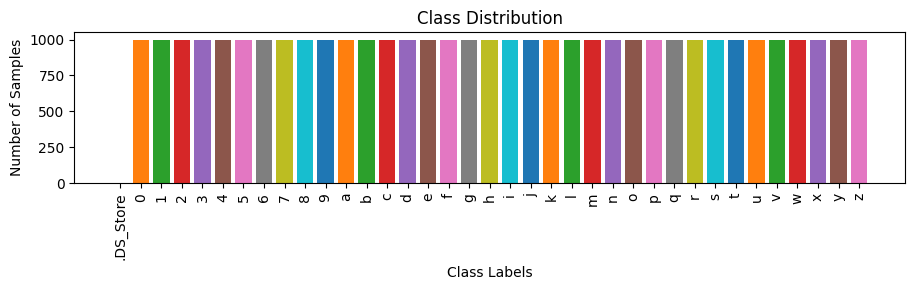

In [7]:
labels = sorted(os.listdir(data_dir))       # get class labels

class_counts = []                           # list to hold counts per class
for label in labels:                        # for each label
    path = os.path.join(data_dir, label)    # get path to label directory
    if not os.path.isdir(path):             # 
        class_counts.append(0)              # append 0 count for non-directory
    else:       
        files = [f for f in os.listdir(path) if f.lower().endswith((".wav", ".flac", ".mp3"))]  # list audio files
        class_counts.append(len(files))     # append count of audio files

colors = [f"C{i%10}" for i in range(len(labels))]   # colors for bars

plt.figure(figsize=(max(6, len(labels)*0.25), 3))   # set figure size
plt.bar(labels, class_counts, color=colors)         # plot bar chart
plt.xlabel("Class Labels")                          # x-axis label
plt.ylabel("Number of Samples")                     # y-axis label
plt.title("Class Distribution")                     # chart title
plt.xticks(rotation=90)                             # rotate x-axis labels
plt.tight_layout()                                  # adjust layout
plt.show()                                          # display plot

#### <span style="color:orange">__Split data sets__</span>
- <span style="color:orange">__Verify spectrogram shape__</span>
- <span style="color:orange">__Convert train/val/test sets to numpy arrays__</span>

In [8]:
label_encoder = LabelEncoder()                                  # initialize label encoder
encoded_labels = label_encoder.fit_transform(target_labels)     # encode string labels to integers


# Split data: 80% training, 20% temp (for validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(audio_data, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels)
# Split temp data: 50% validation, 50% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Display sizes
print(f"Training Set: {len(X_train)}, Validation Set: {len(X_val)}, Test Set: {len(X_test)}")

# pad to same length
max_length = max([spec.shape[0] for spec in audio_data])        # find max length
pad = lambda lst: [np.pad(spec, ((0, max_length - spec.shape[0]), (0, 0)), mode='constant') for spec in lst] # pad function
X_train = pad(X_train)
X_val   = pad(X_val)
X_test  = pad(X_test)

# to numpy arrays
X_train = np.array(X_train)
X_val   = np.array(X_val)
X_test  = np.array(X_test)

''' Verify 80/10/10 split and shapes '''
print("Train shape:", X_train.shape)
print("Val   shape:", X_val.shape)
print("Test  shape:", X_test.shape)

Training Set: 28800, Validation Set: 3600, Test Set: 3600
Train shape: (28800, 58, 128)
Val   shape: (3600, 58, 128)
Test  shape: (3600, 58, 128)


#### - <span style="color:orange">__MD5 hash of raw bytes NumPy array__</span>
- checks for audio duplicates across train/val/test splits
- Reports # of identical files labeled as different classes
- 0 indicates no duplicates
- MD5 collisions extremely unlikely but possible

In [9]:
import hashlib
def h(a): return hashlib.md5(np.ascontiguousarray(a).tobytes()).hexdigest()

# hashes for each split
hash_tr = {h(x) for x in X_train}
hash_va = {h(x) for x in X_val}
hash_te = {h(x) for x in X_test}
print("train∩val:", len(hash_tr & hash_va), "train∩test:", len(hash_tr & hash_te), "val∩test:", len(hash_va & hash_te))

train∩val: 0 train∩test: 0 val∩test: 0


In [10]:
# normalize using TRAIN stats, convert dtypes, recreate dataloaders
mu = X_train.mean(axis=(0,1))
sd = X_train.std(axis=(0,1)) + 1e-9

X_train = ((X_train - mu[None,None,:]) / sd[None,None,:]).astype(np.float32)
X_val   = ((X_val   - mu[None,None,:]) / sd[None,None,:]).astype(np.float32)
X_test  = ((X_test  - mu[None,None,:]) / sd[None,None,:]).astype(np.float32)

y_train = np.array(y_train, dtype=np.int64)
y_val   = np.array(y_val,   dtype=np.int64)
y_test  = np.array(y_test,  dtype=np.int64)


from torch.utils.data import DataLoader, TensorDataset
bs = 32
tr_loader  = DataLoader(TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train)), batch_size=bs, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.from_numpy(X_val),   torch.from_numpy(y_val)),   batch_size=bs, shuffle=False)
te_loader  = DataLoader(TensorDataset(torch.from_numpy(X_test),  torch.from_numpy(y_test)),  batch_size=bs, shuffle=False)

#### <span style="color:orange">__Visual example: Spectrogram vs Audio Waveform__</span>
- morse code characters: j, k, f, 8

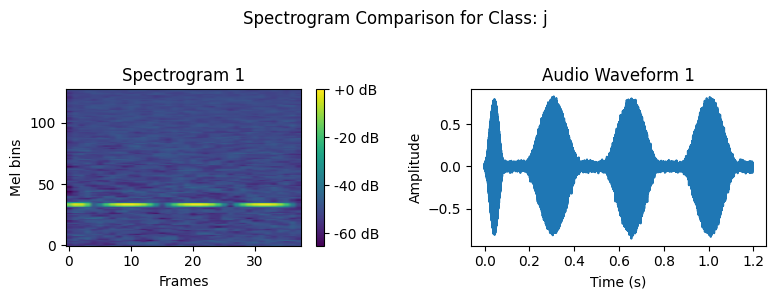

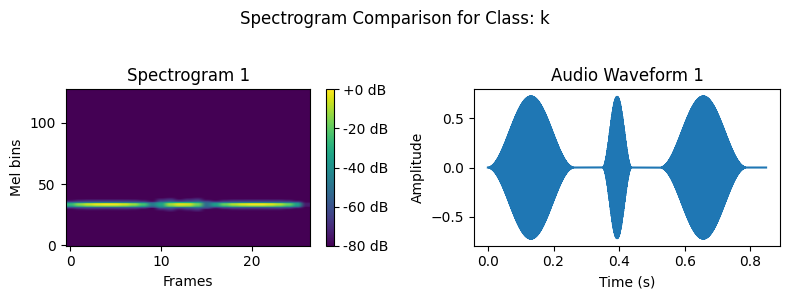

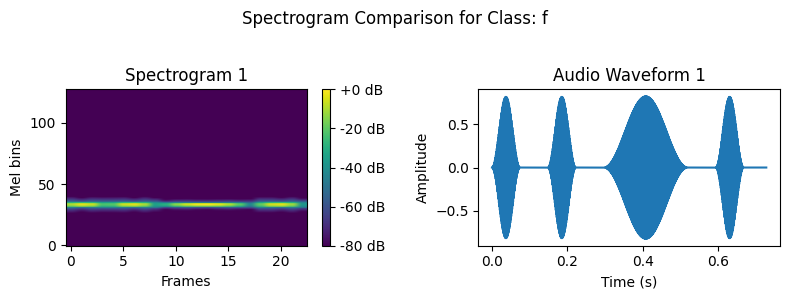

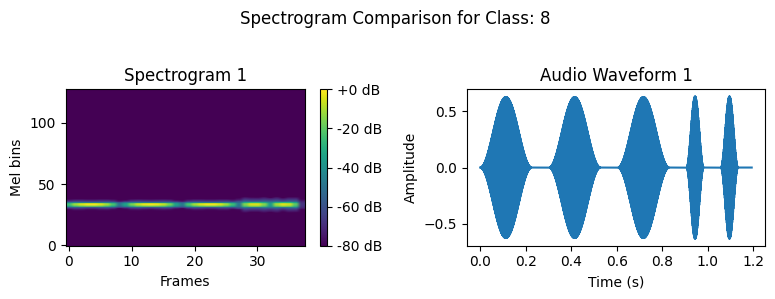

In [11]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt

data_dir = "morse_dataset"

def plot_spectrograms(label, num_samples=3, duration=3.0):
    label_dir = os.path.join(data_dir, label)
    if not os.path.isdir(label_dir):
        print("no such class:", label); return
    files = [f for f in sorted(os.listdir(label_dir)) if f.lower().endswith((".wav", ".mp3", ".flac"))]
    if len(files) == 0:
        print("no audio files in", label_dir); return
    files = files[:max(1, num_samples)]

    plt.figure(figsize=(8, 3 * len(files)))
    plt.suptitle(f"Spectrogram Comparison for Class: {label}")

    for i, audio_file in enumerate(files):
        audio_path = os.path.join(label_dir, audio_file)
        y, sr = librosa.load(audio_path, sr=None, duration=duration)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
        S_db = librosa.power_to_db(S, ref=np.max)

        plt.subplot(len(files), 2, i * 2 + 1)
        plt.title(f"Spectrogram {i + 1}")
        plt.imshow(S_db, aspect="auto", origin="lower", cmap="viridis")
        plt.colorbar(format="%+2.0f dB")
        plt.xlabel("Frames")
        plt.ylabel("Mel bins")

        plt.subplot(len(files), 2, i * 2 + 2)
        plt.title(f"Audio Waveform {i + 1}")
        times = np.linspace(0, len(y) / sr, len(y))
        plt.plot(times, y)
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# example usage:
plot_spectrograms("j", num_samples=1)
plot_spectrograms("k", num_samples=1)
plot_spectrograms("f", num_samples=1)
plot_spectrograms("8", num_samples=1)

#### <span style="color:orange">__TinyTransformer Encoder classifier - training & eval__</span>
- Trains TinyTransCls (encoder‑only Transformer) on time-frequency inputs (expects (N, T, M); will add a length dim if input is 2D).  
- Training: Adam (lr=1e-3), batch=32, epochs=20, CrossEntropyLoss, gradient clipping (1.0); device auto‑selects (mps/cuda/cpu).  
- Validation: computes val loss, accuracy and macro‑F1 each epoch and checkpoints `best_model.pt` by best val accuracy.  
- Outputs: saves `learning_curves.png`, prints final test accuracy/F1 and `classification_report`.

epoch: 1/20 train_loss: 1.5780 val_loss: 0.6158 val_acc: 0.8083 val_f1: 0.7955
Best val_acc so far: 0.8083 at epoch 1
epoch: 2/20 train_loss: 0.4160 val_loss: 0.3037 val_acc: 0.9003 val_f1: 0.9011
Best val_acc so far: 0.9003 at epoch 2
epoch: 3/20 train_loss: 0.1945 val_loss: 0.1829 val_acc: 0.9442 val_f1: 0.9428
Best val_acc so far: 0.9442 at epoch 3
epoch: 4/20 train_loss: 0.1310 val_loss: 0.0737 val_acc: 0.9789 val_f1: 0.9789
Best val_acc so far: 0.9789 at epoch 4
epoch: 5/20 train_loss: 0.0867 val_loss: 0.0907 val_acc: 0.9764 val_f1: 0.9764
Best val_acc so far: 0.9789 at epoch 4
epoch: 6/20 train_loss: 0.0760 val_loss: 0.0507 val_acc: 0.9875 val_f1: 0.9875
Best val_acc so far: 0.9875 at epoch 6
epoch: 7/20 train_loss: 0.0644 val_loss: 0.1552 val_acc: 0.9500 val_f1: 0.9495
Best val_acc so far: 0.9875 at epoch 6
epoch: 8/20 train_loss: 0.0644 val_loss: 0.0340 val_acc: 0.9894 val_f1: 0.9894
Best val_acc so far: 0.9894 at epoch 8
epoch: 9/20 train_loss: 0.0518 val_loss: 0.0274 val_acc:

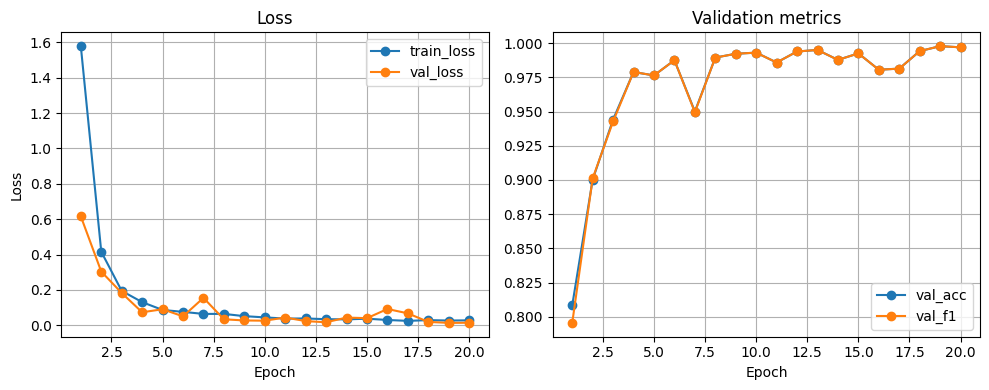

test_acc: 0.9961 test_f1: 0.9961
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       100
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       100
           3       1.00      1.00      1.00       100
           4       1.00      1.00      1.00       100
           5       1.00      1.00      1.00       100
           6       0.99      1.00      1.00       100
           7       0.99      1.00      1.00       100
           8       0.99      1.00      1.00       100
           9       0.99      1.00      1.00       100
          10       1.00      0.99      0.99       100
          11       1.00      0.99      0.99       100
          12       1.00      0.98      0.99       100
          13       1.00      1.00      1.00       100
          14       1.00      1.00      1.00       100
          15       1.00      1.00      1.00       100
          16       0.99      1.00      1.00     

In [12]:
import numpy as np, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# X_train, X_val, X_test, y_train, y_val, y_test exist as numpy arrays
if X_train.ndim == 2:
    X_train = X_train[:, None, :]
    X_val   = X_val[:,   None, :]
    X_test  = X_test[:,  None, :]
T = X_train.shape[1]; M = X_train.shape[2]
NUM_CLASSES = int(np.max(y_train) + 1)

DEVICE = "mps" if (hasattr(torch.backends, "mps") and torch.backends.mps.is_available()) else ("cuda" if torch.cuda.is_available() else "cpu")

class TinyTransCls(nn.Module):
    def __init__(self, in_feats=M, d_model=128, nhead=4, nlayers=2, ff=256, nclass=NUM_CLASSES):
        super().__init__()
        self.fc = nn.Linear(in_feats, d_model)
        self.pos = nn.Parameter(torch.randn(1, T, d_model) * 0.01)
        enc_layer = nn.TransformerEncoderLayer(d_model, nhead, ff, batch_first=True)
        self.encoder = nn.TransformerEncoder(enc_layer, nlayers)
        self.head = nn.Linear(d_model, nclass)
    def forward(self, x):
        x = self.fc(x) + self.pos[:, :x.size(1), :]
        x = self.encoder(x)
        x = x.mean(1)
        return self.head(x)

bs = 32
Xtr = torch.from_numpy(X_train.astype(np.float32)); ytr = torch.from_numpy(y_train.astype(np.int64))
Xval = torch.from_numpy(X_val.astype(np.float32)); yval = torch.from_numpy(y_val.astype(np.int64))
Xte = torch.from_numpy(X_test.astype(np.float32)); yte = torch.from_numpy(y_test.astype(np.int64))

tr_loader = DataLoader(TensorDataset(Xtr, ytr), batch_size=bs, shuffle=True)
val_loader = DataLoader(TensorDataset(Xval, yval), batch_size=bs, shuffle=False)
te_loader = DataLoader(TensorDataset(Xte, yte), batch_size=bs, shuffle=False)

model = TinyTransCls().to(DEVICE)
opt = optim.Adam(model.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()
EPOCHS = 20

# History containers
train_losses = []
val_losses = []
val_accs = []
val_f1s = []

best_val = -1.0
best_ep = None

for ep in range(EPOCHS):
    # --- train epoch (compute average train loss) ---
    model.train()
    running_train_loss = 0.0
    n_train_samples = 0
    for xb, yb in tr_loader:
        xb = xb.to(DEVICE); yb = yb.to(DEVICE)
        logits = model(xb)
        loss = crit(logits, yb)
        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        # accumulate
        batch_n = xb.size(0)
        running_train_loss += loss.item() * batch_n
        n_train_samples += batch_n

    epoch_train_loss = running_train_loss / n_train_samples
    train_losses.append(epoch_train_loss)

    # --- validate each epoch (compute val loss + metrics) ---
    model.eval()
    running_val_loss = 0.0
    n_val_samples = 0
    preds = []; trues = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(DEVICE); yb = yb.to(DEVICE)
            logits = model(xb)
            loss = crit(logits, yb)

            batch_n = xb.size(0)
            running_val_loss += loss.item() * batch_n
            n_val_samples += batch_n

            p = logits.argmax(1).cpu().numpy()
            preds.append(p)
            trues.append(yb.cpu().numpy())

    epoch_val_loss = running_val_loss / n_val_samples
    val_losses.append(epoch_val_loss)

    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    acc = accuracy_score(trues, preds)
    f1 = f1_score(trues, preds, average='macro')
    val_accs.append(acc)
    val_f1s.append(f1)

    print(f"epoch: {ep+1}/{EPOCHS} train_loss: {epoch_train_loss:.4f} val_loss: {epoch_val_loss:.4f} val_acc: {acc:.4f} val_f1: {f1:.4f}")

    # save best model (same logic you had)
    if ep == 0:
        best_val = acc
        best_ep = 1
        torch.save(model.state_dict(), "best_model.pt")
    elif acc > best_val:
        best_val = acc
        best_ep = ep + 1
        torch.save(model.state_dict(), "best_model.pt")
    print(f"Best val_acc so far: {best_val:.4f} at epoch {best_ep}")

# Plot learning curves
epochs = np.arange(1, EPOCHS + 1)

plt.figure(figsize=(10,4))

# Loss subplot
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, marker='o', label='train_loss')
plt.plot(epochs, val_losses, marker='o', label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)

# Metrics subplot (val only)
plt.subplot(1,2,2)
plt.plot(epochs, val_accs, marker='o', label='val_acc')
plt.plot(epochs, val_f1s, marker='o', label='val_f1')
plt.xlabel('Epoch')
plt.title('Validation metrics')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('learning_curves.png', dpi=150)
plt.show()

# final test eval using best model
model.load_state_dict(torch.load("best_model.pt", map_location=torch.device(DEVICE)))
model.eval()
preds=[]; trues=[]
with torch.no_grad():
    for xb, yb in te_loader:
        xb = xb.to(DEVICE)
        logits = model(xb)
        p = logits.argmax(1).cpu().numpy()
        preds.append(p); trues.append(yb.numpy())
preds = np.concatenate(preds); trues = np.concatenate(trues)
acc = accuracy_score(trues, preds); f1 = f1_score(trues, preds, average='macro')
print(f"test_acc: {acc:.4f} test_f1: {f1:.4f}")
print(classification_report(trues, preds))

### <span style="color:orange">__True vs Predicted Scatter Plot__</span>


Total: 3600 Correct: 3586 Accuracy: 0.9961111111111111


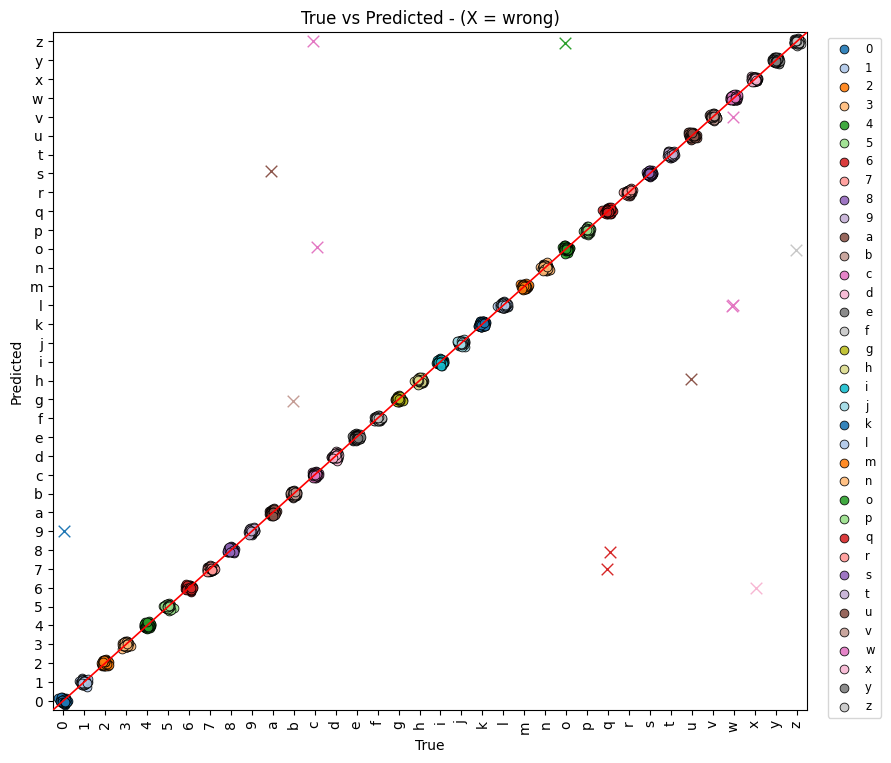

In [13]:
# true vs predicted scatter plot
if 'y_true' not in globals() or 'y_pred' not in globals():
    y_true_list, y_pred_list = [], []
    model.to(DEVICE).eval()
    with torch.no_grad():
        for xb,yb in te_loader:
            out = model(xb.to(DEVICE))
            y_pred_list.append(out.argmax(1).cpu().numpy())
            y_true_list.append(yb.numpy())
    y_true = np.concatenate(y_true_list); y_pred = np.concatenate(y_pred_list)

# labels
if 'label_encoder' in globals():
    labels = list(label_encoder.classes_)
elif 'labels' in globals():
    labels = list(labels)
else:
    labels = [str(i) for i in range(int(max(y_true.max(), y_pred.max())+1))]

cmap = plt.cm.get_cmap('tab20')                             # get colormap
colors = [cmap(i % cmap.N) for i in range(len(labels))]     # colors for each label
N = len(y_true)                                             # number of samples
jx = np.random.normal(scale=0.08, size=N); jy = np.random.normal(scale=0.08, size=N)    # jitter

plt.figure(figsize=(9,8))

for i,name in enumerate(labels):
    m = (y_true == i)
    if not m.any(): continue
    corr = m & (y_pred == y_true)
    wrong = m & (y_pred != y_true)
    if corr.any():
        plt.scatter(y_true[corr]+jx[corr], y_pred[corr]+jy[corr],
                    s=40, marker='o', facecolor=colors[i], edgecolor='k', linewidth=0.6, alpha=0.9, label=name)
    if wrong.any():
        plt.scatter(y_true[wrong]+jx[wrong], y_pred[wrong]+jy[wrong],
                    s=70, marker='x', color=colors[i], linewidths=1.0, zorder=4)

lims = (-0.5, len(labels)-0.5)
plt.plot(lims, lims, '-', color='red', linewidth=1.2, zorder=5)
plt.xlim(lims); plt.ylim(lims)
plt.xticks(range(len(labels)), labels, rotation=90); plt.yticks(range(len(labels)), labels)
plt.xlabel("True"); plt.ylabel("Predicted")
plt.title("True vs Predicted - (X = wrong)")
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left', fontsize='small')
plt.tight_layout()
print("Total:", N, "Correct:", int((y_true==y_pred).sum()), "Accuracy:", float((y_true==y_pred).mean()))
plt.show()

### <span style="color:orange">__Confusion matrix (3‑panel)__</span>
- row‑normalized recall (PowerNorm)
- raw counts (log scale)
- off‑diagonal errors
- requires y_true and y_pred in the workspace (optional `labels`).

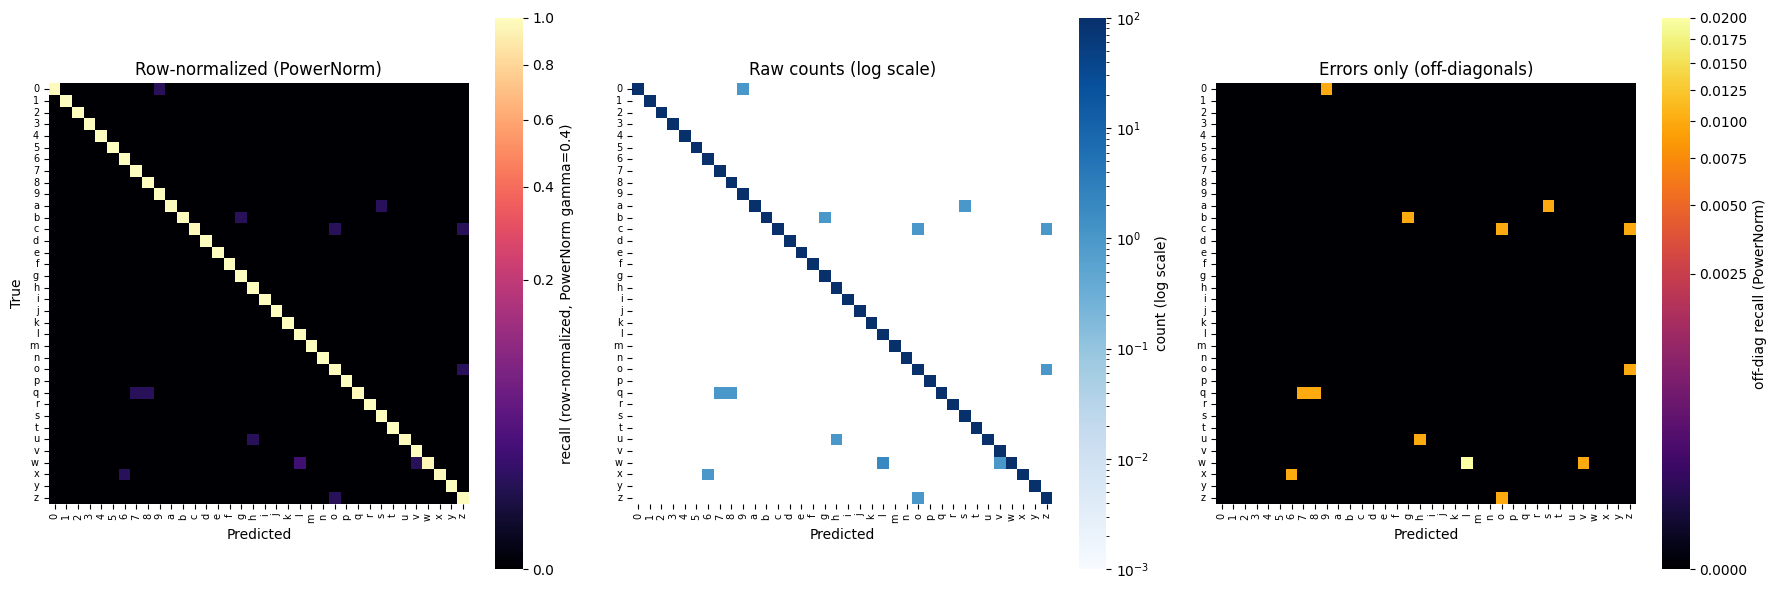

In [14]:
# confusion matrix 
import numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import confusion_matrix
from matplotlib import colors

# requires y_true, y_pred in workspace; optional 'labels' list
if 'y_true' not in globals() or 'y_pred' not in globals():
    raise RuntimeError("y_true / y_pred not found. Run evaluation first.")

yt = np.array(y_true); yp = np.array(y_pred)

# build simple tick labels
if yt.dtype.kind in ('U','S','O') or yp.dtype.kind in ('U','S','O'):
    all_labels = sorted(list(np.unique(np.concatenate([yt, yp]).astype(str))))
    lab2i = {l:i for i,l in enumerate(all_labels)}
    yi = np.array([lab2i[str(x)] for x in yt])
    pi = np.array([lab2i[str(x)] for x in yp])
    tick_labels = all_labels
else:
    yi = yt.astype(int); pi = yp.astype(int)
    if 'labels' in globals() and len(labels) >= (max(yi.max(), pi.max())+1):
        tick_labels = labels[:max(yi.max(), pi.max())+1]
    else:
        tick_labels = [str(i) for i in range(max(yi.max(), pi.max())+1)]

cm = confusion_matrix(yi, pi, labels=range(len(tick_labels)))
with np.errstate(divide='ignore', invalid='ignore'):
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    cm_norm[np.isnan(cm_norm)] = 0.0

n = len(tick_labels)
fig, axes = plt.subplots(1,3, figsize=(18,6), gridspec_kw={'width_ratios':[1,1,1]})

# 1) Row-normalized with PowerNorm to boost small nonzero values
ax = axes[0]
pn = colors.PowerNorm(gamma=0.4, vmin=0.0, vmax=1.0)
sns.heatmap(cm_norm, ax=ax, cmap='magma', norm=pn, cbar_kws={'label':'recall (row-normalized, PowerNorm gamma=0.4)'}, xticklabels=tick_labels, yticklabels=tick_labels, square=True)
ax.set_title("Row-normalized (PowerNorm)")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.tick_params(axis='x', rotation=90, labelsize=7); ax.tick_params(axis='y', rotation=0, labelsize=7)

# 2) Raw counts with LogNorm (shows magnitude differences)
ax = axes[1]
if cm.max() > 0:
    ln = colors.LogNorm(vmin=max(cm.min(), 1e-3), vmax=max(cm.max(), 1))
    sns.heatmap(cm, ax=ax, cmap='Blues', norm=ln, cbar_kws={'label':'count (log scale)'}, xticklabels=tick_labels, yticklabels=tick_labels, square=True)
else:
    sns.heatmap(cm, ax=ax, cmap='Blues', cbar_kws={'label':'count'}, xticklabels=tick_labels, yticklabels=tick_labels, square=True)
ax.set_title("Raw counts (log scale)")
ax.set_xlabel("Predicted"); ax.set_ylabel("")
ax.tick_params(axis='x', rotation=90, labelsize=7); ax.tick_params(axis='y', rotation=0, labelsize=7)

# 3) Errors-only (off-diagonals) with its own scale
ax = axes[2]
err = cm_norm.copy()
np.fill_diagonal(err, 0)
if err.max() > 0:
    pn2 = colors.PowerNorm(gamma=0.3, vmin=0.0, vmax=err.max())
    sns.heatmap(err, ax=ax, cmap='inferno', norm=pn2, cbar_kws={'label':'off-diag recall (PowerNorm)'},
                xticklabels=tick_labels, yticklabels=tick_labels, square=True)
else:
    sns.heatmap(err, ax=ax, cmap='inferno', xticklabels=tick_labels, yticklabels=tick_labels, square=True)
ax.set_title("Errors only (off-diagonals)")
ax.set_xlabel("Predicted"); ax.set_ylabel("")
ax.tick_params(axis='x', rotation=90, labelsize=7); ax.tick_params(axis='y', rotation=0, labelsize=7)

plt.tight_layout()
plt.show()

### <span style="color:orange">__Interactive 3D true‑vs‑pred scatter__</span>
- per‑class colored points (correct = circles, errors = X)
- small jitter to reduce overlap
- red diagonal (perfect predictions)
- requires y_true and y_pred in the workspace (optional labels or label_encoder)
- Saves true_vs_pred_3d.html
- opens an interactive Plotly view.

In [15]:
import numpy as np
import plotly.graph_objects as go
from plotly.colors import qualitative

# inputs required: y_true, y_pred, labels (optional)
assert 'y_true' in globals() and 'y_pred' in globals(), "y_true and y_pred must exist"
y_true = np.asarray(y_true).astype(int)
y_pred = np.asarray(y_pred).astype(int)
N = len(y_true)

# build label names (reuse your earlier logic)
if 'label_encoder' in globals():
    labels = list(label_encoder.classes_)
elif 'labels' in globals():
    labels = list(labels)
else:
    labels = [str(i) for i in range(int(max(y_true.max(), y_pred.max()) + 1))]

# color palette
colors = qualitative.Plotly

# small jitter to spread points in z and avoid exact overlap
jx = np.random.normal(scale=0.08, size=N)
jy = np.random.normal(scale=0.08, size=N)
jz = np.random.normal(scale=0.18, size=N)  # vertical stacking jitter

fig = go.Figure()

# loop by true label to preserve coloring by true class (change to y_pred if you prefer)
for i, name in enumerate(labels):
    mask = (y_true == i)
    if not mask.any():
        continue

    ok = mask & (y_pred == y_true)      # correct examples
    err = mask & (y_pred != y_true)     # wrong examples
    color = colors[i % len(colors)]

    if ok.any():
        idxs = np.where(ok)[0]
        hover_ok = [f"idx:{int(j)}<br>true:{name}<br>pred:{labels[int(y_pred[j])]}" for j in idxs]
        fig.add_trace(go.Scatter3d(
            x=(y_true[idxs].astype(float) + jx[idxs]),
            y=(y_pred[idxs].astype(float) + jy[idxs]),
            z=jz[idxs],
            mode='markers',
            marker=dict(size=6, color=color, symbol='circle', line=dict(width=0.5, color='black')),
            name=f"{name} (ok)",
            legendgroup=name,
            showlegend=True,
            hovertext=hover_ok, hoverinfo='text'
        ))

    if err.any():
        idxs = np.where(err)[0]
        hover_err = [f"idx:{int(j)}<br>true:{name}<br>pred:{labels[int(y_pred[j])]}" for j in idxs]
        fig.add_trace(go.Scatter3d(
            x=(y_true[idxs].astype(float) + jx[idxs]),
            y=(y_pred[idxs].astype(float) + jy[idxs]),
            z=jz[idxs],
            mode='markers',
            marker=dict(size=4, color=color, symbol='x', line=dict(width=1.0, color='black')),
            name=f"{name} (err)",
            legendgroup=name,
            showlegend=True,
            hovertext=hover_err, hoverinfo='text'
        ))

# diagonal perfect-prediction line at z=0
L = len(labels)
diag_x = list(range(L))
diag_y = list(range(L))
diag_z = [0.0] * L
fig.add_trace(go.Scatter3d(
    x=diag_x, y=diag_y, z=diag_z,
    mode='lines',
    line=dict(color='red', width=3),
    name='perfect (x=y)',
    showlegend=True
))

fig.update_layout(
    title="3D silhouette (z = silhouette)",
    width=1100, height=800,
    scene=dict(
        xaxis_title='Embedding dim 1',
        yaxis_title='Embedding dim 2',
        zaxis_title='Silhouette',
        domain=dict(x=[0.12, 0.72], y=[0.1, 0.98])   # reduce scene width to leave room on right; raise scene slightly
    ),
    legend=dict(
        x=1.02,            # place legend to the right of the plotting area (paper coords)
        y=1.0,
        xanchor='left',
        yanchor='top',
        itemsizing='constant'
    ),
    margin=dict(t=80, b=20, l=20, r=200)   # increase right margin to fit long legend
)

# optional save & show
fig.write_html("true_vs_pred_3d.html", include_plotlyjs='cdn')
fig.show()

### <span style="color:orange">__PCA 3D of model embeddings__</span>
- extract (or reuse) test embeddings via the encoder (mean‑pooled)
- standardize and run PCA→3D
- plot a class‑colored 3D scatter (circles = correct, X = errors)
- printing explained variance and test accuracy
- requires model + te_loader + DEVICE (or precomputed y_true/y_pred and optional labels).

Total: 3600 Correct: 3586 Accuracy: 0.9961111111111111


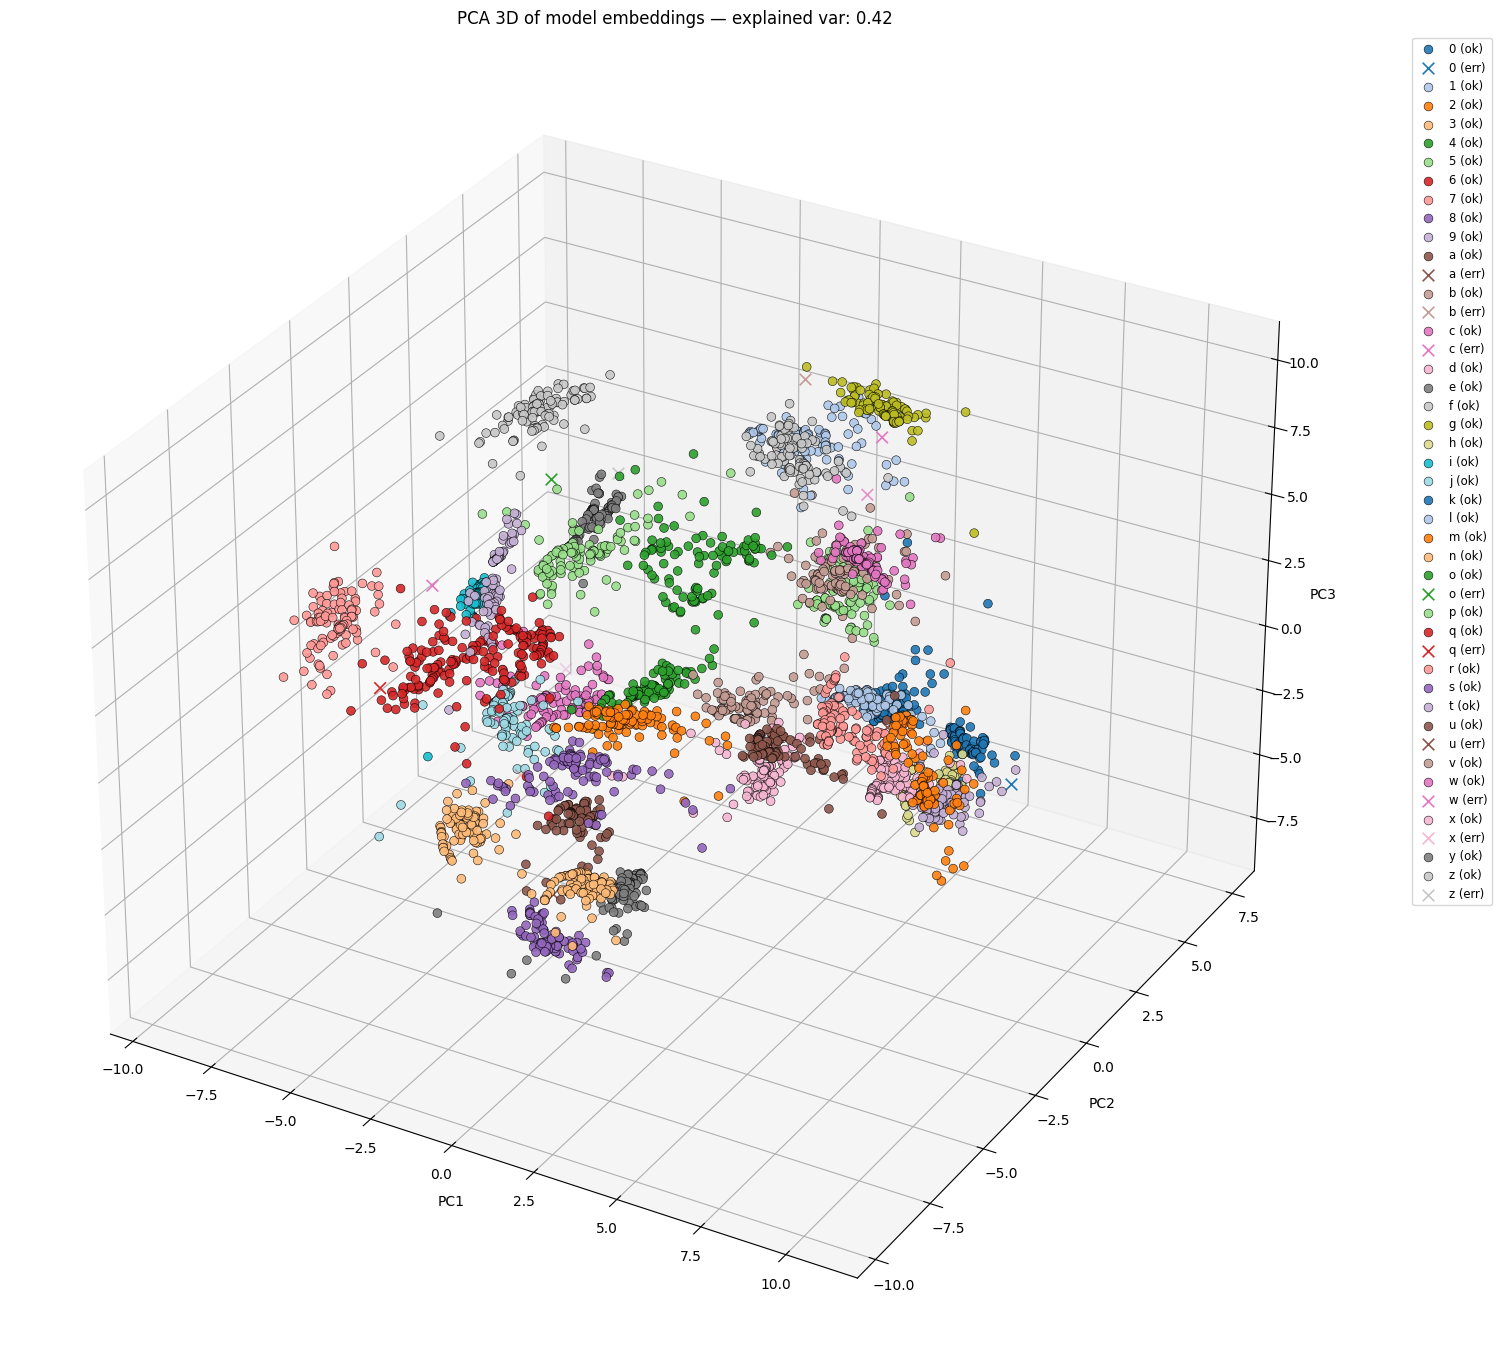

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# --- compute y_true, y_pred on test set if not available ---
if 'y_true' not in globals() or 'y_pred' not in globals():
    y_true_list, y_pred_list = [], []
    model.to(DEVICE).eval()
    with torch.no_grad():
        for xb,yb in te_loader:
            xb = xb.to(DEVICE)
            out = model(xb)
            y_pred_list.append(out.argmax(1).cpu().numpy())
            y_true_list.append(yb.numpy())
    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)

# --- get embeddings from the model ---
def get_embeddings(model, loader, device):
    emb_list = []
    model.eval()
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            x = model.fc(xb) + model.pos[:, :xb.size(1), :]
            x = model.encoder(x)
            x = x.mean(1)
            emb_list.append(x.cpu().numpy())
    return np.concatenate(emb_list)

embs = get_embeddings(model, te_loader, DEVICE)   # shape (N, d_model)

# --- scale + PCA to 3D ---
scaler = StandardScaler()
embs_s = scaler.fit_transform(embs)
pca = PCA(n_components=3)
emb3 = pca.fit_transform(embs_s)
explained = pca.explained_variance_ratio_.sum()

# --- label names ---
if 'label_encoder' in globals():
    labels = list(label_encoder.classes_)
elif 'labels' in globals():
    labels = list(labels)
else:
    labels = [str(i) for i in range(int(max(y_true.max(), y_pred.max())+1))]

# --- plotting (matplotlib 3D) ---
cmap = plt.cm.get_cmap('tab20')
colors = [cmap(i % cmap.N) for i in range(len(labels))]
N = len(y_true)
jx = np.random.normal(scale=0.0, size=N)  # set jitter > 0 if desired
jy = np.random.normal(scale=0.0, size=N)
jz = np.random.normal(scale=0.0, size=N)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

for i, name in enumerate(labels):
    mask = (y_true == i)
    if not mask.any():
        continue
    corr = mask & (y_pred == y_true)
    wrong = mask & (y_pred != y_true)

    if corr.any():
        ax.scatter(emb3[corr,0] + jx[corr], emb3[corr,1] + jy[corr], emb3[corr,2] + jz[corr],
                   s=40, marker='o', facecolor=colors[i], edgecolor='k', linewidth=0.4, alpha=0.9,
                   label=f"{name} (ok)")
    if wrong.any():
        ax.scatter(emb3[wrong,0] + jx[wrong], emb3[wrong,1] + jy[wrong], emb3[wrong,2] + jz[wrong],
                   s=70, marker='x', color=colors[i], linewidths=1.2, zorder=4,
                   label=f"{name} (err)")

ax.set_title(f"PCA 3D of model embeddings — explained var: {explained:.2f}")
ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")

# tidy legend (avoid duplicate labels)
handles, lbls = ax.get_legend_handles_labels()
by_label = dict(zip(lbls, handles))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

print("Total:", N, "Correct:", int((y_true==y_pred).sum()),
      "Accuracy:", float((y_true==y_pred).mean()))
plt.tight_layout()
plt.show()
# optionally save: plt.savefig('pca_3d.png', dpi=150)

### <span style="color:orange">__PCA analysis on scaled embeddings (embs_s)__</span>
- fits PCA
- prints top‑10 PC variances and PC counts for 50%/80% explained variance
- plots a cumulative scree plus a bar chart of the first 20 PCs.

Top PCs (percent var): [16.58 13.24 11.7  10.19  8.31  7.34  7.19  5.84  4.55  3.8 ]
PCs for 50% variance: 4
PCs for 80% variance: 8


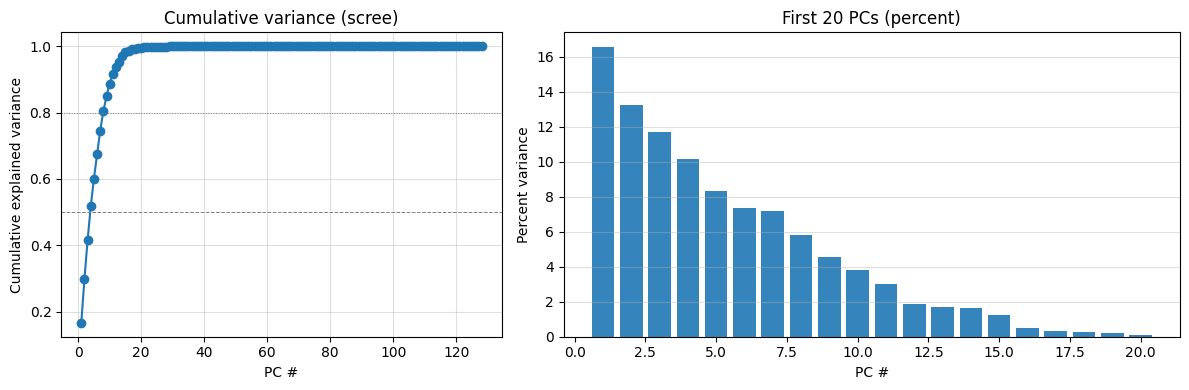

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA().fit(embs_s)                      # full PCA on scaled embeddings
evr = pca.explained_variance_ratio_

# Pretty printed top PCs
top_k = 10
print("Top PCs (percent var):", np.round(evr[:top_k]*100, 2))

# How many PCs to reach thresholds
cum = np.cumsum(evr)
for thresh in (0.5, 0.8):
    pcs_needed = np.searchsorted(cum, thresh) + 1
    print(f"PCs for {int(thresh*100)}% variance:", pcs_needed)

# Scree / cumulative plot + bar for first 20 PCs
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4), gridspec_kw={'width_ratios':[1,1.4]})
ax1.plot(np.arange(1, len(cum)+1), cum, marker='o')
ax1.axhline(0.5, color='gray', ls='--', lw=0.7); ax1.axhline(0.8, color='gray', ls=':', lw=0.7)
ax1.set_xlabel('PC #'); ax1.set_ylabel('Cumulative explained variance'); ax1.set_title('Cumulative variance (scree)')
ax1.grid(alpha=0.4)

k = min(20, len(evr))
ax2.bar(np.arange(1,k+1), evr[:k]*100, color='C0', alpha=0.9)
ax2.set_xlabel('PC #'); ax2.set_ylabel('Percent variance'); ax2.set_title(f'First {k} PCs (percent)')
ax2.grid(axis='y', alpha=0.4)
plt.tight_layout()
plt.show()

Above information--^

- Summary: 
- Top 3 PCs ≈ 41.7% variance (moderately representative).  
- Top 4 PCs ≈ 52.0%; top 5 ≈ 60.9%.  
- Top 9 PCs ≈ 82.6% (≈80% threshold), top 10 ≈ 86.7%.  
- Implication: a 2–3D PCA plot loses >50% of variance  

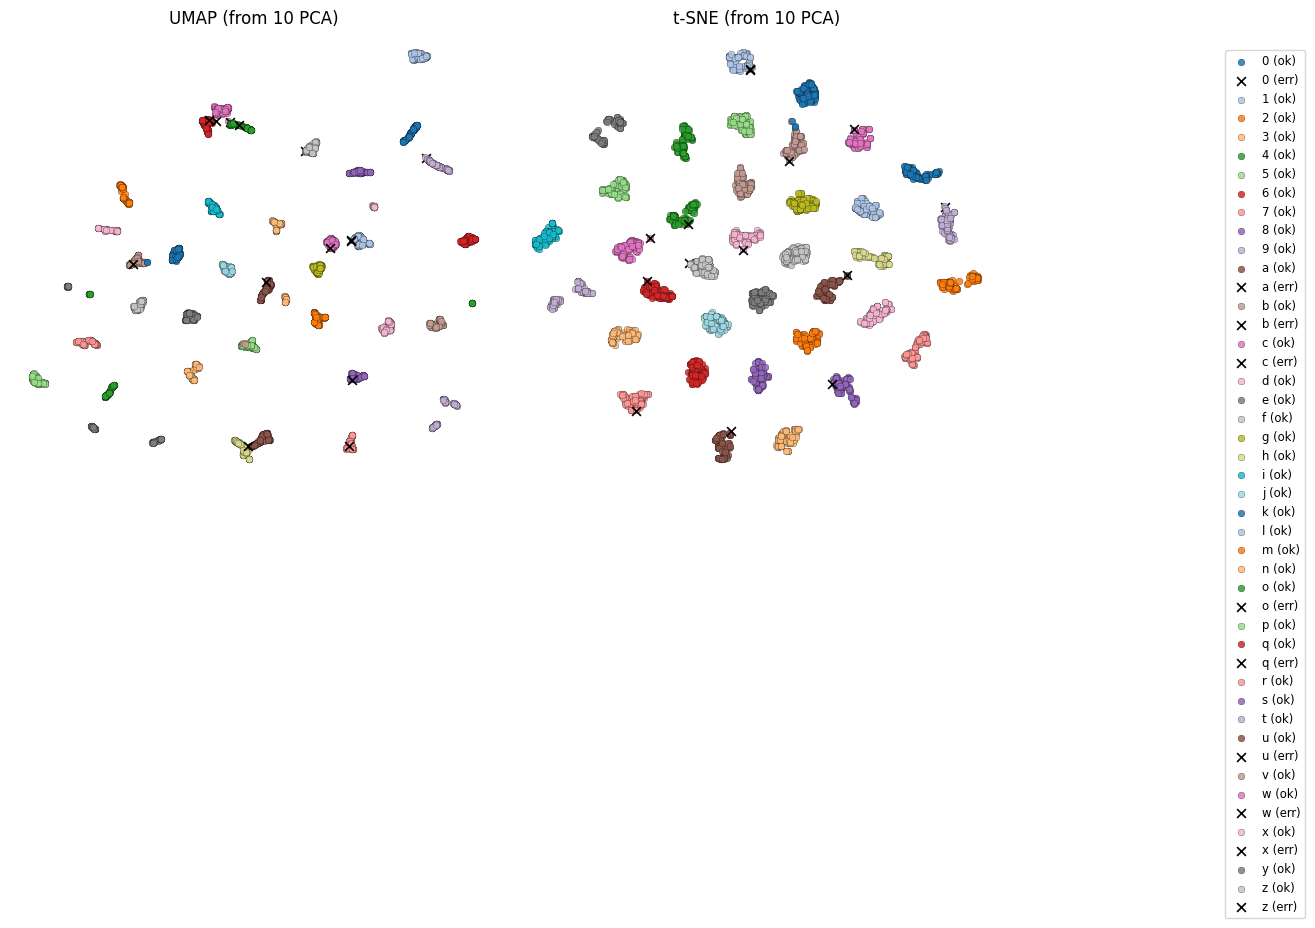

In [ ]:
# PCA -> (optional) UMAP and t-SNE visualization (fixed subplot/legend logic)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# --- Prepare scaled embeddings (embs or embs_s must exist) ---
if 'embs_s' in globals():
    X = embs_s
else:
    assert 'embs' in globals(), "embs or embs_s must be in workspace"
    X = StandardScaler().fit_transform(embs)

# --- PCA to n components (recommend 9-10 based on variance analysis) ---
n_pca = 10
pca = PCA(n_components=n_pca, random_state=0)
X_pca = pca.fit_transform(X)

# --- UMAP (optional) and t-SNE on PCA components ---
X_umap = None
try:
    import umap.umap_ as umap
    X_umap = umap.UMAP(n_components=2, random_state=0, min_dist=0.1).fit_transform(X_pca)
except Exception:
    X_umap = None  # umap not available

X_tsne = TSNE(n_components=2, init='pca', random_state=0, perplexity=30).fit_transform(X_pca)

# --- labels / ground truth / predictions (optional) ---
y = np.asarray(y_true) if 'y_true' in globals() else None
yhat = np.asarray(y_pred) if 'y_pred' in globals() else None
has_preds = (y is not None) and (yhat is not None)
if 'label_encoder' in globals():
    labels = list(label_encoder.classes_)
elif 'labels' in globals():
    labels = list(labels)
elif y is not None:
    labels = [str(int(i)) for i in np.unique(y)]
else:
    labels = None

# --- prepare plots list and create subplots  ---
plots = []
if X_umap is not None:
    plots.append(('UMAP (from 10 PCA)', X_umap))
plots.append(('t-SNE (from 10 PCA)', X_tsne))

nplots = len(plots)
fig, axs = plt.subplots(1, nplots, figsize=(6 * nplots, 5))
if nplots == 1:
    axs = [axs]  # make iterable

cmap = plt.cm.get_cmap('tab20')
all_handles = []
all_labels = []

# --- plot each projection, color by true label; mark errors with 'x' ---
for ax, (title, Z) in zip(axs, plots):
    if y is None:
        h = ax.scatter(Z[:, 0], Z[:, 1], s=12, alpha=0.8)
        all_handles.append(h); all_labels.append('points')
    else:
        for cls in np.unique(y):
            mask = (y == cls)
            if not mask.any():
                continue
            color = cmap(int(cls) % cmap.N)
            # correct
            ok = mask & (yhat == y) if has_preds else mask
            if ok.any():
                h_ok = ax.scatter(Z[ok, 0], Z[ok, 1], s=24, color=color,
                                  alpha=0.85, edgecolor='k', linewidth=0.2,
                                  label=f"{labels[int(cls)] if labels is not None else int(cls)} (ok)")
                all_handles.append(h_ok); all_labels.append(f"{labels[int(cls)] if labels is not None else int(cls)} (ok)")
            # errors
            if has_preds:
                err = mask & (yhat != y)
                if err.any():
                    h_err = ax.scatter(Z[err, 0], Z[err, 1], s=40, marker='x',
                                       color='k', linewidths=1.2,
                                       label=f"{labels[int(cls)] if labels is not None else int(cls)} (err)")
                    all_handles.append(h_err); all_labels.append(f"{labels[int(cls)] if labels is not None else int(cls)} (err)")
    ax.set_title(title)
    ax.axis('off')

# --- dedupe legend entries while preserving order ---
seen = set()
uniq_handles = []
uniq_labels = []
for h, l in zip(all_handles, all_labels):
    if l not in seen:
        seen.add(l)
        uniq_handles.append(h)
        uniq_labels.append(l)

# place legend in unused right margin
fig.legend(uniq_handles, uniq_labels, bbox_to_anchor=(1.02, 0.9), loc='upper left', fontsize='small')

# leave room on right for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1.0])
plt.show()

# option to save figure
# fig.savefig('pca10_umap_tsne.png', dpi=150, bbox_inches='tight')


- UMAP (from top‑10 PCA)
- t‑SNE (from top‑10 PCA)
- colored by true class (legend at right)
- correct vs error markers shown.  
- Many classes form tight, well‑separated clusters -> embeddings largely discriminate classes.  
- Some clusters overlap or contain error points -> specific class confusions remain.  
- Note: these are 2D projections of PCA(10) - useful but can be lossy
---
---


### <span style="color:orange">__UMAP 3D (after PCA->50) of scaled model embeddings__</span>

- Silhouette score
- Points colored by true class
- filled circles = correct
- X = errors
- Interpretation:
- compact clusters indicate good class separation
- overlapping clusters or clustered X markers point to class confusions.  


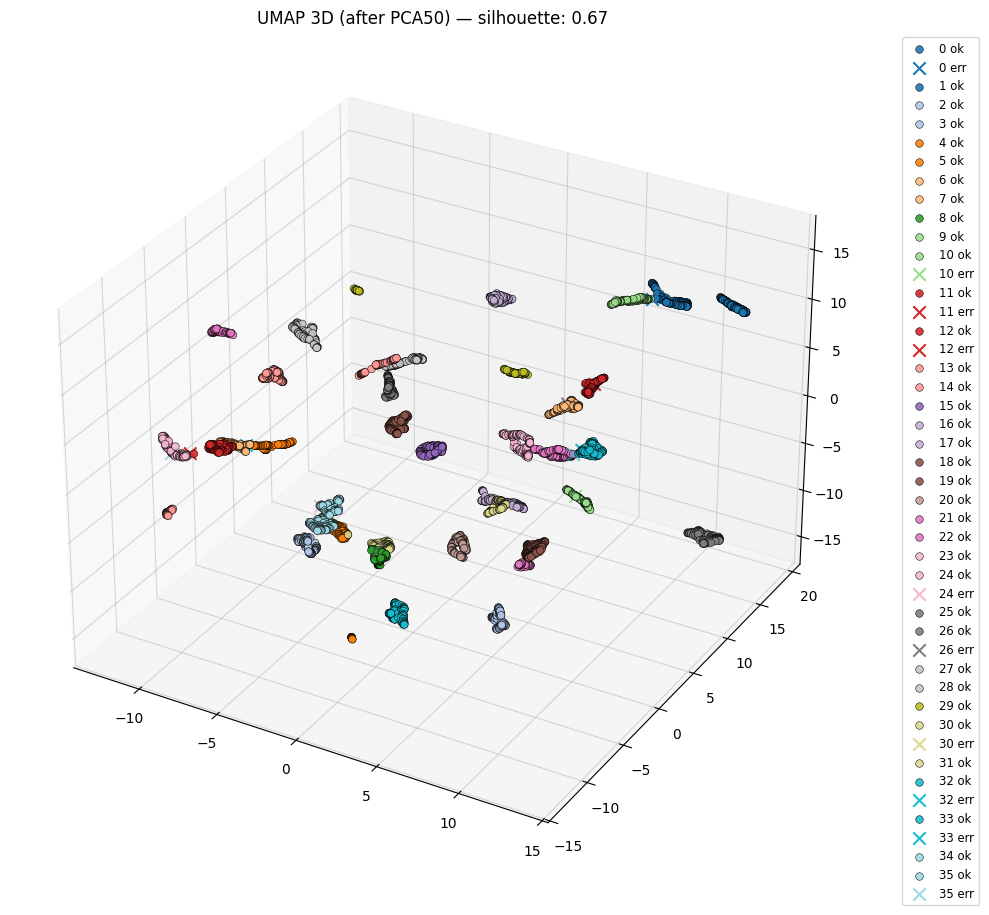


Number of classes: 36
Total: 3600 Correct: 3586 Accuracy: 0.9961111111111111
Silhouette score: 0.6706587672233582
Explained var by PCA50: 0.99987614

***** End of Notebook *****


In [29]:

# inputs: embs (N,d), y_true (N,), y_pred (N,)
from sklearn.metrics import silhouette_score
scaler = StandardScaler(); embs_s = scaler.fit_transform(embs)
pca50 = PCA(n_components=min(50, embs_s.shape[1]), random_state=42).fit(embs_s)
emb_pca50 = pca50.transform(embs_s)

reducer3 = umap.UMAP(n_components=3, random_state=42, min_dist=0.3)
emb3 = reducer3.fit_transform(emb_pca50)

sil = silhouette_score(emb3, y_true) if len(np.unique(y_true))>1 else np.nan

# plot 3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
cmap = plt.cm.get_cmap('tab20', len(np.unique(y_true)))
for i, lab in enumerate(np.unique(y_true)):
    mask = (y_true == lab)
    ok = mask & (y_pred == y_true)
    err = mask & (y_pred != y_true)
    ax.scatter(emb3[ok,0], emb3[ok,1], emb3[ok,2], s=30, color=cmap(i),edgecolor='k', linewidth=0.4, alpha=0.9, label=f"{lab} ok")
    if err.any():
        ax.scatter(emb3[err,0], emb3[err,1], emb3[err,2], s=80, marker='x', color=cmap(i), linewidths=1.5, label=f"{lab} err")

ax.set_title(f"UMAP 3D (after PCA50) — silhouette: {sil:.2f}")
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05,1), loc='upper left', fontsize='small')

ax.grid(True, linestyle='--', alpha=0.6)
ax.xaxis._axinfo['grid']['color'] = (0.7,0.7,0.7,0.5)
ax.yaxis._axinfo['grid']['color'] = (0.7,0.7,0.7,0.5)
ax.zaxis._axinfo['grid']['color'] = (0.7,0.7,0.7,0.5)

plt.grid(True)
plt.tight_layout()
plt.show()
print()
print("Number of classes:", len(np.unique(y_true)))
print("Total:", len(y_true), "Correct:", int((y_true==y_pred).sum()),
      "Accuracy:", float((y_true==y_pred).mean()))
print("Silhouette score:", sil)
print("Explained var by PCA50:", np.sum(pca50.explained_variance_ratio_))
print()
print("***** End of Notebook *****")
